In [2]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import scipy.fftpack as fft

In [45]:
# Load data
x = wav.read('hr2.wav')
print('Sample rate: {} \n\nData {}'.format(x[0], x[1]))

Sample rate: 44100 

Data [[-576 -125]
 [1529  335]
 [-642 -141]
 ..., 
 [ 146  125]
 [ 150  125]
 [ 144  129]]


/Users/kirill/anaconda/envs/400project/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [53]:
print('Total number of samples: {}'.format(len(x[1])))

signal_time = len(x[1]) / 44100
print('Total time of signal     {}'.format(signal_time))

# There were ~21 heart beats in this audio file
approx_hr = 60/(signal_time/21)
print('Approximate heart rate:  {}'.format(approx_hr))

Total number of samples: 661048
Total time of signal     14.989750566893424
Approximate heart rate:  84.05743607120814


In [47]:
data = x[1]

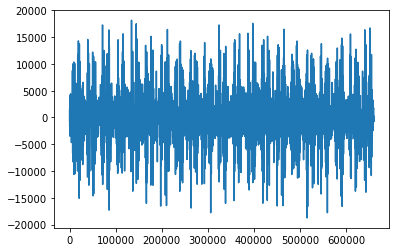

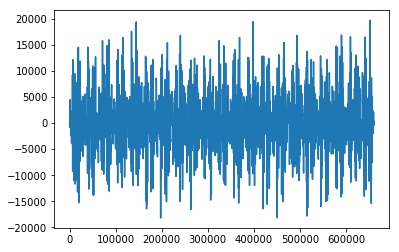

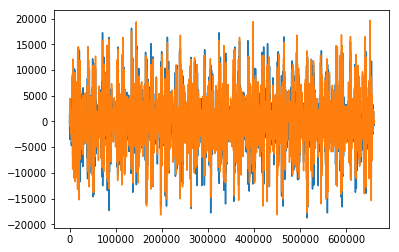

In [48]:
# Plot all the audio data

# Left channel
plt.plot(data[:,0])
plt.show()

# Right channel
plt.plot(data[:,1])
plt.show()

# Both on same graph
plt.plot(data[:,:])
plt.show()

[ -2.28070500e+06  -5.40616970e+06  -1.10301266e+07 ...,  -1.22224966e+03
  -9.21754929e+03   7.73000000e+02]


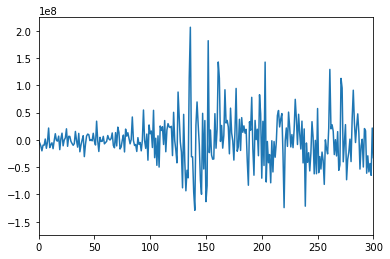

In [49]:
fourier_data = fft.rfft(data[:,1])
print(fourier_data)

plt.plot(fourier_data)
plt.xlim([0,300])
plt.show()

In [50]:
from aubio import source, tempo
from numpy import median, diff

def get_file_bpm(path, params=None):
    """ Calculate the beats per minute (bpm) of a given file.
        path: path to the file
        param: dictionary of parameters
    """
    if params is None:
        params = {}
    # default:
    samplerate, win_s, hop_s = 44100, 1024, 512
    if 'mode' in params:
        if params.mode in ['super-fast']:
            # super fast
            samplerate, win_s, hop_s = 4000, 128, 64
        elif params.mode in ['fast']:
            # fast
            samplerate, win_s, hop_s = 8000, 512, 128
        elif params.mode in ['default']:
            pass
        else:
            print("unknown mode {:s}".format(params.mode))
    # manual settings
    if 'samplerate' in params:
        samplerate = params.samplerate
    if 'win_s' in params:
        win_s = params.win_s
    if 'hop_s' in params:
        hop_s = params.hop_s

    s = source(path, samplerate, hop_s)
    samplerate = s.samplerate
    o = tempo("specdiff", win_s, hop_s, samplerate)
    # List of beats, in samples
    beats = []
    # Total number of frames read
    total_frames = 0

    while True:
        samples, read = s()
        is_beat = o(samples)
        if is_beat:
            this_beat = o.get_last_s()
            beats.append(this_beat)
            #if o.get_confidence() > .2 and len(beats) > 2.:
            #    break
        total_frames += read
        if read < hop_s:
            break

    def beats_to_bpm(beats, path):
        # if enough beats are found, convert to periods then to bpm
        if len(beats) > 1:
            if len(beats) < 4:
                print("few beats found in {:s}".format(path))
            bpms = 60./diff(beats)
            return median(bpms)
        else:
            print("not enough beats found in {:s}".format(path))
            return 0

    return beats_to_bpm(beats, path)


In [75]:
bpm = get_file_bpm('hr2.wav')
print('The found heart rate is:    {}'.format(bpm))
print('The manually counted HR is: {}'.format(approx_hr))

print('Error percentage:           {:.2%}'.format((bpm-approx_hr)/approx_hr))

The found heart rate is:    84.4530414180532
The manually counted HR is: 84.05743607120814
Error percentage:           0.47%
